# Loading packages

In [1]:
import os

os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
import numpy as np
import torch
import random
import torch.nn.functional as F
import torchvision
import pickle
import gc
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from diffusers import DDPMScheduler, UNet2DModel, DDPMPipeline
from tqdm.auto import tqdm


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


In [2]:
IMAGE_SIZE = 64
BATCH_SIZE = 32
N_EPOCH = 10
MANUAL_SEED = 1
print("Random Seed: ", MANUAL_SEED)
random.seed(MANUAL_SEED)
torch.manual_seed(MANUAL_SEED)
torch.cuda.manual_seed(MANUAL_SEED)
torch.use_deterministic_algorithms(True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Random Seed:  1


# Loading data

In [3]:
# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Map to (-1, 1)
    ]
)

In [4]:
dataset = torchvision.datasets.ImageFolder("lsun_bedroom", transform=preprocess)
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6
)


# Models

In [5]:
def train_model_and_save(scheduler, name):
    # Create a model
    model = UNet2DModel(
        sample_size=IMAGE_SIZE,  # the target image resolution
        in_channels=3,  # the number of input channels, 3 for RGB images
        out_channels=3,  # the number of output channels
        layers_per_block=2,  # how many ResNet layers to use per UNet block
        block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
        down_block_types=(
            "DownBlock2D",  # a regular ResNet downsampling block
            "DownBlock2D",
            "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",
            "UpBlock2D",  # a regular ResNet upsampling block
        ),
    )
    model.to(device)
    noise_scheduler = scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

    losses = []

    for epoch in tqdm(range(N_EPOCH), desc="Epoch"):
        for step, batch in enumerate(train_dataloader):
            clean_images = batch[0].to(device)
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            # Get the model prediction
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

            # Calculate the loss
            loss = F.mse_loss(noise_pred, noise)
            loss.backward(loss)
            losses.append(loss.item())
            # Update the model parameters with the optimizer
            optimizer.step()
            optimizer.zero_grad()

        loss_last_epoch = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
        print(f"Epoch:{epoch + 1}, loss: {loss_last_epoch}")

    image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)
    image_pipe.save_pretrained(os.path.join("diffusion_models", name))
    images_one = image_pipe(batch_size=32).images
    images_two = image_pipe(batch_size=32).images
    connected_images = images_one + images_two
    grid = image_grid(connected_images, 8, 8)
    return grid, losses, connected_images

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:1, loss: 0.03683153765476044
Epoch:2, loss: 0.023834296523506947
Epoch:3, loss: 0.02252845054085927
Epoch:4, loss: 0.021919981870164366
Epoch:5, loss: 0.021502662758533356
Epoch:6, loss: 0.021462973835015376
Epoch:7, loss: 0.021134296758439572
Epoch:8, loss: 0.02081497642110845
Epoch:9, loss: 0.020788468970667155
Epoch:10, loss: 0.020743960157983736


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

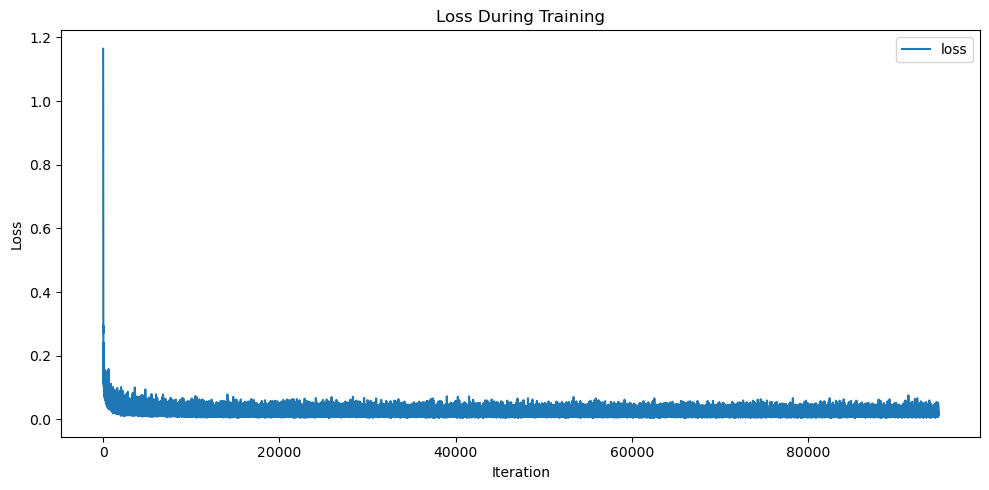

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:1, loss: 0.056779925013526335
Epoch:2, loss: 0.04251726208712639
Epoch:3, loss: 0.04080918317966051
Epoch:4, loss: 0.040160516925627235
Epoch:5, loss: 0.03947191867367051
Epoch:6, loss: 0.039134587160161514
Epoch:7, loss: 0.0389959477581289
Epoch:8, loss: 0.038854707054857544
Epoch:9, loss: 0.03838099354411473
Epoch:10, loss: 0.038495988652104594


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

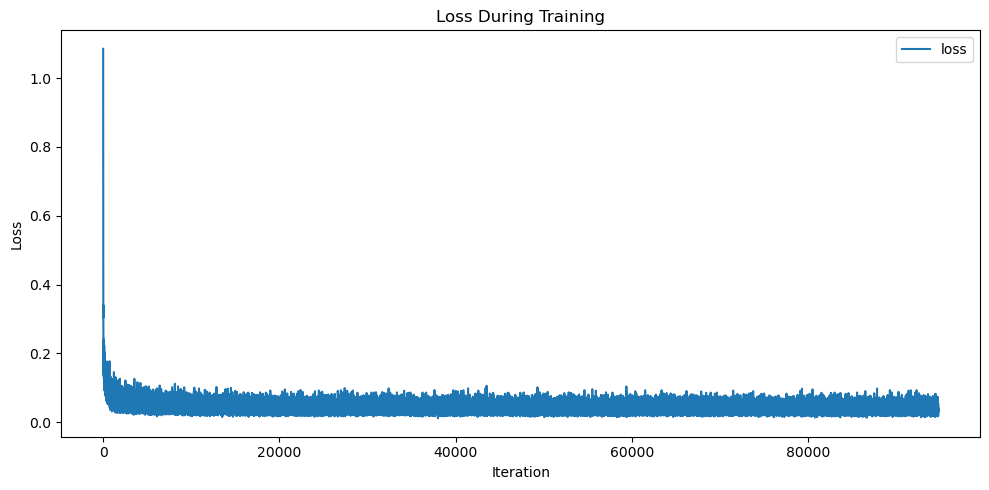

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:1, loss: 0.05491831681623176
Epoch:2, loss: 0.04005468831952375
Epoch:3, loss: 0.03838056412428243
Epoch:4, loss: 0.03756028427949371
Epoch:5, loss: 0.036998990305070104
Epoch:6, loss: 0.03665530167667123
Epoch:7, loss: 0.036389290412364314
Epoch:8, loss: 0.0362190481136305
Epoch:9, loss: 0.03594286040729644
Epoch:10, loss: 0.03603266019871205


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
for scheduler, name in [(DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear"), "linear"),
                        (DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"), "cosine"),
                        (DDPMScheduler(num_train_timesteps=1000, beta_schedule="sigmoid"), "sigmoid")]:
    os.makedirs("diffusion_models", exist_ok=True)
    grid, losses, connected_images = train_model_and_save(scheduler, name)

    path = os.path.join("diffusion_models", "outputs", name)
    os.makedirs(path, exist_ok=True)
    with open(os.path.join(path, "images.pkl"), "wb") as handle:
        pickle.dump(connected_images, handle)

    grid.save(os.path.join(path, f"grid.png"), format="png")
    grid.show()

    np.savetxt(os.path.join(path, f"loss.txt"), np.array(losses))

    plt.figure(figsize=(10, 5))
    plt.title("Loss During Training")
    plt.plot(losses, label="loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(path, f"loss_plot.png"), dpi=300)
    plt.show()

    gc.collect()
